In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import asn1tools

In [2]:
# read metadata
meta_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'

with open(meta_filename, 'r') as f:
    meta_data = json.load(f)

In [3]:
data_type = meta_data['global']['core:datatype']
Fs = meta_data['global']['core:sample_rate']

if data_type == 'cf32_le':
    dtype = np.complex64
elif data_type == 'ci16_le':
    dtype = np.int16
elif data_type == 'ci8_le':
    dtype = np.int8
else:
    raise ValueError(f"Unsupported data type: {data_type}")

Fs

30720000

In [4]:
# read data
data_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(data_filename, 'rb') as f:
    tmp = np.fromfile(f,dtype=dtype)  # Adjust dtype as needed

In [5]:
scale = 2**(-15)
rx = scale*tmp[0::2] + scale*1j*tmp[1::2]

In [6]:
fc = 10e6
rx_unfr = rx*np.exp(-2j*np.pi*fc*np.arange(len(rx))/Fs)

h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)
rxf = np.convolve(rx_unfr,h)

In [7]:
rxf = rxf[::2]
Fs = Fs//2

# system parameters
N_FFT = Fs//15000
N_CP = 144//2 # normal CP
N_CP_extra = 16//2
half_frame = (Fs*5)//1000 # 5 ms 

## Cell search section

### PSS

In [8]:
def seq_zadoff_chu(u):

    n = np.arange(63)
    d_u = np.exp(-1j*np.pi*u*n*(n+1)/63)
    d_u[31] = 0
    
    return d_u


def zadoff_chu(u,N_FFT):

    zc = seq_zadoff_chu(u)
    
    # mapping to resource elements
    re = np.zeros(N_FFT,complex)
    re[N_FFT//2-31:N_FFT//2+32] = zc
    
    return np.fft.ifft(np.fft.ifftshift(re)) 




### SSS

In [9]:
def tilde_s():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+2] ^ x[i] # xor operation
                
    return 1-2.0*x

def tilde_c():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+3] ^ x[i] # xor operation
        
    return 1-2.0*x

def tilde_z():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+4] ^ x[i+2] ^ x[i+1] ^ x[i] # xor operation
        
    return 1-2.0*x

def m_01(N_id_1):
    
    q_prime = N_id_1 // 30
    q = (N_id_1 + q_prime*(q_prime+1)/2) // 30
    m_prime = N_id_1 + q*(q+1)/2
    m_0 = int(m_prime % 31)
    m_1 = int((m_0+m_prime//31+1) % 31)
    
    return (m_0,m_1)

def m_sequence(N_id_1,N_id_2,F,N_FFT):
    
    # F: 0 or 1, denoting first half or second half
    
    m_0,m_1 = m_01(N_id_1)
    ts = tilde_s()
    tc = tilde_c()
    tz = tilde_z()
    # print(ts)
    
    c_0 = np.roll(tc,-N_id_2) # left cyclic shift operation 
    c_1 = np.roll(tc,-N_id_2-3) 
    
    s_0 = np.roll(ts,-m_0) 
    s_1 = np.roll(ts,-m_1) 
    
    z_10 = np.roll(tz,-(m_0%8))
    z_11 = np.roll(tz,-(m_1%8))
    
    d = np.zeros(62)
    if F == 0:
        
        d[0::2] = s_0 * c_0
        d[1::2] = s_1 * c_1 * z_10
    elif F == 1:
        
        d[0::2] = s_1 * c_0
        d[1::2] = s_0 * c_1 * z_11
                
    re = np.zeros(N_FFT)
    re[N_FFT//2-31:N_FFT//2] = d[:31]
    re[N_FFT//2+1:N_FFT//2+32] = d[31:]
    
    # return time domain SSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

### Cell search

In [10]:
class cell_search(object):
    
    def __init__(self,N_FFT,N_CP,Fs,buf_size=2):
        
        self.shift_reg = [None] * buf_size
        self.prior_sym = []
        self.N_FFT = N_FFT
        self.N_CP = N_CP
        self.pss_start = None
        self.N_id_2 = None
        self.N_id_1 = None
        self.n_sym = 0
        self.Fs = Fs
        
        # pss,sss and norm
        self.pss = []
        self.pss_norm = np.zeros(3)
        
        self.sss = [[]]* 3
        self.sss_norm = np.zeros((3,2*168))
        
        u = [25,29,34]
        for n in range(3):
            self.pss.append(zadoff_chu(u[n],self.N_FFT))
            self.pss_norm[n] = np.linalg.norm(self.pss[n])
            for m in range(168):
                for F in range(2):
                    self.sss[n].append(m_sequence(m,n,F,N_FFT)) 
                    # even: first half, odd: second half.
                    # N_id_1, N_id_2
                    self.sss_norm[n,2*m+F] = np.linalg.norm(self.sss[n][m])
    
    def queue(self,data):
        
        self.n_sym += 1
         
        self.prior_sym = self.shift_reg.pop(0) # prior
        self.shift_reg.append(data) # append new
                
    
    def match_pss(self,threshold=0.5):
        # 1. shift_reg has none (start)
        # 2. shift_reg has data

        if any(sym is None for sym in self.shift_reg):
            return (self.n_sym,self.pss_start,self.N_id_2) # start
        else:
            sym_blocks = np.concatenate(self.shift_reg)
                
        # search
        search = True
        ind = self.N_FFT
        max_corr = 0
        while search and ind < len(sym_blocks):

            sym = sym_blocks[ind-self.N_FFT:ind]
            for n in range(3):
                corr = np.abs(np.sum(sym*np.conj(self.pss[n])))/np.linalg.norm(sym)/self.pss_norm[n]
                if corr > threshold:
                    if corr > max_corr: # we find the peak
                        max_corr = corr
                    else:
                        search = False
                        self.N_id_2 = n
                        self.pss_start = ind-self.N_FFT-1
            
            ind += 1 
        
        return (self.n_sym-2,self.pss_start,self.N_id_2)
    
    
    def compute_fd(self):
        
        sym_blocks = np.concatenate(self.shift_reg)
        sym = sym_blocks[self.pss_start:self.pss_start+self.N_FFT]
        sym_pss = sym*np.conj(self.pss[self.N_id_2])
        
        pl = np.sum(sym_pss[:N_FFT//2])
        pu = np.sum(sym_pss[N_FFT//2:])

        return np.angle(pu*np.conj(pl))/(2*np.pi*self.N_FFT//2) * Fs
    
    
    def reset_pss(self):
        
        self.pss_start = None
        
    
                
        
    def match_sss(self):
        # after successfully match pss, the position of sss is known.
        prior_blocks = np.concatenate((self.prior_sym,self.shift_reg[0]))
        
        # print(self.pss_start)
        sss_start = self.pss_start - self.N_CP # pss - n_cp at the prior sym
        sym = prior_blocks[sss_start:sss_start+self.N_FFT]
        
        corr = np.zeros(2*168)
        for m in range(2*168):
            corr[m] = np.abs(np.sum(sym*np.conj(self.sss[self.N_id_2][m]))/np.linalg.norm(sym)/np.linalg.norm(self.sss_norm[self.N_id_2][m]))
        
        max_corr_ind = np.argmax(corr)
        self.N_id_1 = max_corr_ind//2
        
        return (self.N_id_1,max_corr_ind%2) # (N_id_1,F)
        
        
        
    def update_nsym(self,n_sym): # consider this later based on n_frame, n_sym
        
        self.n_sym = n_sym
    
    # def __str__          
    
    def __call__(self,data): 
        
        self.queue(data)
        
        pss_nsym,pss_start,N_id_2 = self.match_pss()
        
        if pss_start != None: # pss is successfully decoded.
            f_d = self.compute_fd()
            N_id_1,F = self.match_sss()
            # print('pss located at sample index: {:d}, N_id_2: {:d}'.format(pss_nsym*self.N_FFT+pss_start,N_id_2))
            # print('Found the current slot in the {:s} half frame, with N_id_1 = {:d}'.format('first' if F==0 else 'second',N_id_1))
            self.reset_pss()
            N_id = N_id_1*3 + N_id_2 # compute pci
            return [(N_id,pss_nsym,pss_start,f_d,F)] # we can also generate text information.

            
            

In [11]:
win = N_FFT

cs = cell_search(N_FFT,N_CP,Fs)

ob_len = half_frame*2 + N_FFT
# ob_len = 10*N_FFT

while win < ob_len:
    
    data = rxf[win-N_FFT:win]
    result = cs(data)
    win += N_FFT
    if result != None:
        info = result    
        
info

[(324, 129, 509, 1343.469605511858, 0)]

After successfully decoding PSS and SSS, the control information will be sent back to the controller.
Controller will then dispatch the corresponding symbols to PBCH.

## CRS section

In [12]:
def extract_OFDM(ofdm_symbol,N_rb,N_rb_sc=12):
    
    re = np.fft.fftshift(np.fft.fft(ofdm_symbol))
    
    # length of occupied subcarriers
    N_sc = N_rb*N_rb_sc
    N_FFT = len(ofdm_symbol)
        
    # since we want to read the information in REs, we need to skip DC
    active_sc = np.concatenate((np.arange(N_FFT//2-N_sc//2,N_FFT//2),np.arange(N_FFT//2+1,N_FFT//2+N_sc//2+1)))
    
    return re[active_sc]

In [13]:
# TS 36.211, 7.2
def c_sequence(M,c_init,Nc=1600):
    
    x_1 = np.zeros(M+Nc,dtype=np.uint8)
    x_1[0] = 1
    for n in range(31,M+Nc):
        x_1[n] = x_1[n-28] ^ x_1[n-31]
        
    x_2 = np.zeros(M+Nc,dtype=np.uint8)
    for n in range(31):
        x_2[n] = (c_init & (1<<n)) >> n 
    for n in range(31,M+Nc):
        x_2[n] = x_2[n-28] ^ x_2[n-29] ^ x_2[n-30] ^ x_2[n-31]
    
    return x_1[Nc:] ^ x_2[Nc:]    

# TS 36.211, 6.10.1.1
def crs_sequence(ns,l,N_id,N_cp=1,N_rb_max=110):
    
    # ns: slot number.
    # l: OFDM symbol number
    
    c_init = 2**10*(7*(ns+1)+l+1)*(2*N_id+1)+2*N_id+N_cp
    c = c_sequence(4*N_rb_max,c_init)
    
    return np.sqrt(0.5)*((1-2.0*c[0::2]) + 1j*(1-2.0*c[1::2]))

# TS 36.211 6.10.1.2, note figure.
def crs_in_re(p,l,ns,N_id,N_rb,N_rb_max=110):
    
    # p: antenna port number
    # l: OFDM symbol number
    # ns: slot number
    
    nu = -1
    if p == 0 and l == 0:
        nu = 0
    elif p == 0 and l == 4:
        nu = 3
    elif p == 1 and l == 0:
        nu = 3
    elif p == 1 and l == 4:
        nu = 0
    elif p == 2 and l == 1: 
        nu = 3*(ns%2) 
    elif p == 3 and l == 1:
        nu = 3 + 3*(ns%2) 
        
    if nu == -1:
        return (None,None)
        
    nu_shift = N_id % 6
    
    cs = crs_sequence(ns,l,N_id)
    
    m = np.arange(2*N_rb)
    m_prime = m + N_rb_max - N_rb
    crs = cs[m_prime] # value of crs
    
    k = 6*m + (nu + nu_shift) % 6 # index of crs
    
    return (k,crs) 

In [14]:
class channel_estimate(object):
    
    def __init__(self,N_id,N_CP,N_CP_extra,Fs,ant,N_dl_sc=12):
        
        self.ns = 0
        self.N_id = N_id
        self.N_rb = None
        self.N_dl_sc = N_dl_sc
        self.N_CP = N_CP
        self.N_CP_extra = N_CP_extra
        self.Fs = Fs
        self.ant = ant
        
        self.k = [[]]*ant
        self.crs = [[]]*ant
        
        self.h_sym = []
        self.data0 = {}
    
    def update_rb(self,N_rb):
        self.N_rb = N_rb
        
    def update_hsym(self):
        self.h_sym = np.zeros((self.ant,self.N_rb*self.N_dl_sc),complex)
            
    def update_crs(self,data): 
        self.ns = data['ns']
        # if data['l'] in [0,4]:
        for p in range(2):
            # if p < 2:
            #     l = 0
            # else:
            #     l = 1
            self.k[p],self.crs[p] = crs_in_re(p,data['l'],self.ns,self.N_id,self.N_rb)
         
    def update_sys(self,data):
        if self.N_rb != data['rb']:
            self.update_rb(data['rb'])
            self.update_hsym()
            
        if data['l'] in [0,4]:
            self.update_crs(data)
            
    def strip_cp(self,data):
        if data['l'] == 0:
            return data['sym'][self.N_CP+self.N_CP_extra:]    
        else:
            return data['sym'][self.N_CP:]
    
    def est_h(self,data): # based on one subframe.

        l = data['l']
        re_sym = data['sym']
        if l in [0,4]:
            self.h_sym[0][self.k[0]] = re_sym[self.k[0]] * np.conj(self.crs[0])
            if self.ant == 2:
                self.h_sym[1][self.k[1]] = re_sym[self.k[1]] * np.conj(self.crs[1]) 
        # elif l == 1 and self.ant == 4:
        #     for p in [3,4]:
        #         self.h_sym[p][self.k[p]] = re_sym[self.k[p]] * np.conj(self.crs[p])      
             
        # intepolation in k (freq)
        for p in range(self.ant):
            for kk in range(self.N_rb*self.N_dl_sc):
                n = self.k[p][np.argmin(np.abs(self.k[p] - kk))]
                self.h_sym[p][kk] = self.h_sym[p][n]
                
        data['h'] = self.h_sym
        
        return data
                        
    def intepolate(self,data): # in time
        
        data['h'] = self.h_sym
        
        return data
    
            
    def __call__(self,data): # a dictionary of data that has ns item
                               
        self.update_sys(data)
                            
        sym = self.strip_cp(data)
        
        # correcting frequency offset
        sym = sym*np.exp(-2j*np.pi*data['fd']*(np.arange(len(sym))+data['l']*N_FFT)/self.Fs) 

        data['sym'] = extract_OFDM(sym,self.N_rb) # bw truncation
        
        # symbol selection: we focus on 2 antenna
        if self.ant <= 2:
            if data['l'] in [0,4]:  
                data = self.est_h(data)
            else:
                data = self.intepolate(data)
              
        # print(data['h'][0][0])   
        # print('***************************')     
        # print('***************************')     
        # print('***************************')     

        return data
    
        # else:
        #     if data['l'] in [0,4]:
        #         data = self.est_h(data)
        #         # store sym0
        #         self.data0 = data
        #         return None
        #     elif data['l'] in [1]:
        #         data = self.est_h(data)
        #         # now can intepolate both sym0 and sym1
        #         self.data0 = self.intepolate(self.data0)
        #         data = self.intepolate(data)
                
        #         return (self.data0,data)
        #     else:
        #         data = self.intepolate(data)
            
        #         return data
            

In [15]:
N_id = 324
pss_start = 286205
F = 0
pbch_start = pss_start + N_FFT # start of slot 1
N_rb = 6
ns = 1
f_d = 1379.3996018718585
ant = 2

ce = channel_estimate(N_id,N_CP,N_CP_extra,Fs,ant)
collector = []

for l in range(4):
    if l == 0:
        CP = N_CP + N_CP_extra
    else:
        CP = N_CP
        
    data = {'sym':rxf[pbch_start:pbch_start+N_FFT+CP],'ns':ns,'l':l,'rb':N_rb,'fd':f_d,'h':[]}
    data = ce(data)
    # if l == 1:
    #     print(data['sym'])
    #     print(data['sym'].size)
    collector.append(data)
    # print(data['h'].shape)
    
    pbch_start += N_FFT + CP

### MIB decoding

In [16]:
def Alamouti_combine(r,H0,H1):
    "perform combing of two symbols for an Alamouti STC"
    scale = abs(H0[0::2])**2 + abs(H1[1::2])**2
    d = np.zeros_like(r)

    d[0::2] =  (H0[0::2].conjugate() * r[0::2] + H1[1::2] * r[1::2].conjugate()) / scale
    d[1::2] = ((-H1[0::2].conjugate() * r[0::2] + H0[1::2] * r[1::2].conjugate()) /scale).conjugate()

    return d

In [17]:
def qpsk_demodulate(x):
    "QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x), dtype=np.uint8)

    for n in range(len(x)):
        b[2*n] = 0 if np.real(x[n]) > 0 else 1
        b[2*n+1] = 0 if np.imag(x[n]) > 0 else 1

    return b

In [18]:
def pbch_descrambling(M_bit,N_id,bits):
    c = c_sequence(M_bit,N_id)
    n_bits = len(bits)
    threshold = 0.9
    
    for rv in range(4):
        ds_bits = bits ^ c[rv*n_bits:(rv+1)*n_bits]
        if np.sum(ds_bits[:120] == ds_bits[120:240])/120 > threshold:
            # print('The decoding MIB is from the redundency version {:d}'.format(rv))
            break
        
    return (ds_bits,rv)
    

In [19]:
def subblock_interleaver(seq,col_perm_table):
    "subblock interleaving of coded streams"
    N_cc = 32    
    D = len(seq)
    
    DUMMY = D+10000

    R = D // N_cc
    if R * N_cc < D:
        R = R + 1
        
    # prepend dummy symbols, these 
    N_dummy = R*N_cc - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )

    # read row-wise into a matrix
    M = np.reshape(y, (R, N_cc))
    
    # permute the columns of the matrix
    P = np.zeros_like(M)
    for n in range(N_cc):
        P[:, n] = M[:, col_perm_table[n]]

    # transpose and reshape P to give the output vector
    v = np.reshape(P.T, -1)

    # remove the dummy symbols
    e = v[v != DUMMY]

    return e

In [20]:
def pbch_rate_matching(ds_bits):
    # the table for permuting columns of the matrix are given in TS 36.212,  Table 5.1.4-1
    col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                            0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])

    ## construct the permutation table
    ind  = np.arange(40)                   # indices 0 to 39
    perm_table = subblock_interleaver(ind,col_perm_table) # pass indices to interleaver to obtain the permutation table

    coded_bits = np.zeros((3,40),dtype=np.uint8)

    for n in range(3):
        coded_bits[n,perm_table] = ds_bits[n*40:(n+1)*40] 
        
    return coded_bits  
    

In [21]:
# helper function: count the number of 1-bits in an integer
def count_ones(n):
    "count the number of 1-bits in an integer"
    b = 0
    while n != 0:
        b += n & 0x1
        n = n >> 1

    return b

# helper function to find the total number of bits in an integer
def count_bits(n):
    "count the number of 0 and 1-bits in an integer"
    b = 0
    while n != 0:
        b += 0x1
        n = n >> 1

    return b

def hamming_dist(obs, ref):
    "Compute the Hamming distance between two sequences of integers"
    return np.sum( ref != obs)

In [22]:
class ConvCoder(object):
    "Class to implement convolution FEC coding"
    
    def __init__(self, generators_list):
        """The convolutional code is described by a list of generator polynomials. Each 
        generator polynomial is summarized by an integer that captures the connections from
        the shift register to the coded bits.
        
        From the generators, the structural properties of the code can be deduced:
        * the number of bits in the generators determines the length of the shift register
        * the number of generators determines the code rate

        The standard specifies three specific generators (`0o133`, `0o171`, and `0o165`) 
        for a rate 1/3 code with a constraint length of 6 delays in the shift register. 
        This implementation is generic and supports arbitrary generators.
        """
        self.n_codes = len(generators_list)
        self.order = max([count_bits(n) for n in generators_list]) - 1
        self.generators = generators_list

        self.Nt = 2 ** (self.order + 1) # number of prossible outputs in each bit period
        self.Ns = 2 ** self.order       # number of states of the shift register

        # table of possible outputs
        self._t = np.empty((self.Nt, self.n_codes), dtype=np.uint8)
        for n in range(self.Nt):
            # loop over all possible bit patterns of length order+1
            for m in range(self.n_codes):
                self._t[n, m] = count_ones(n & self.generators[m]) & 0x1

    def decode(self, d, cost_fun):
        """Decode a sequence of observations using the Viterbi algorithm
        
        Inputs:
        * d - 2D array of observations; leading dimension must be equal to self.n_codes
        * cost_fun - function to measure similarity; use `Hamming_dist` for hard decision observations,
                     and `L2_dist` for soft decisions

        Returns:
        vector of bits; length is equal to the second dimension of `d`
        """
        assert d.shape[0] == self.n_codes, "Leading dimension of d must match number of generators"

        # initialization
        N = d.shape[1]             # number of input observations; also number of outputs
        costs = np.zeros(self.Ns)  # accumulated similarity metric
        # sequences of estimated bits; one for each register state
        survivors = 127 * np.zeros([self.Ns, N], dtype=np.uint8)

        for n in range(N):
            # temporary storage for the following loops; these are updated during the first phase
            # and then copied to the permanent variables in the second phase. This is needed
            # to prevent that intermediate results are overwritten prematurely
            tmp_cost = np.inf * np.ones(self.Ns)
            # tmp_ts = np.zeros(self.Ns, dtype=np.uint8)
            tmp_b = np.zeros(self.Ns, dtype=np.uint8)
            tmp_survivors = survivors[:, :n].copy()  # this copy is critical - grrrr
            
            obs = d[:, n]  # outputs for this bit period

            # update costs and survivor extensions; the key to the algorithm is
            # that there are possible 2^7 bit patterns in each bit period. The 6 most
            # significant bits form the state at the end of the bit period. The 6 least
            # significant bits define the state at the start of the period. Hence, there
            # are only two possible beginning states to reach an end state. For each end state
            # we only keep the path that with the smaller cost metric. 
            for te in np.arange(self.Ns, dtype=np.uint8):
                # loop over all states at the end of this bit period
                for b in np.arange(2, dtype=np.uint8):
                    # loop ver the LSB of the beginning states; this is the 
                    # only bit that's not also in te
                    # b is the LSB of t and ts
                    t = (te << 1) + b      # t combines the bits of ts and te 
                    ts = t & (self.Ns - 1) # state at the start of period
                    # compute cost recursively: cost at the start of the priod +
                    # cost associated with the difference betwee observation and
                    # coded bits for this transition from ts to te
                    c = costs[ts] + cost_fun(obs, self._t[t, :])
                    #if n == 1 and c == 0:
                    #    print(te, t, ts, c, survivors[ts, :n])
                    if c < tmp_cost[te]:
                        # store results if this is the lowest cost path to te
                        tmp_cost[te] = c
                        # capture the MSB of t (and te); that's the current bit
                        tmp_b[te] = (t & self.Ns) >> (self.order)
                        # tmp_ts[te] = ts
                        tmp_survivors[te, :] = survivors[ts, :n]

            # copy the updates to permanent variables for next iteration
            for te in np.arange(self.Ns, dtype=np.uint8):
                costs[te] = tmp_cost[te]
                survivors[te, :n] = tmp_survivors[te, :]
                survivors[te, n] = tmp_b[te]

                #if n == 1 and costs[te] == 0:
                #    print(te, tmp_ts[te], tmp_b[te], tmp_survivors[te, :], survivors[te, :n+1])
                
        # all done, find the lowest cost and return the corrponding survivor
        ind_survivor = np.argmin(costs)
        return survivors[ind_survivor, :], costs[ind_survivor]


    def encode(self, bits, init_state=None):
        """convolutional encoder
        
        Inputs:
        bits - information bits to be encoded
        init_state - initial state for the register (default: initialize via tail-biting; i.e., 
        use last elements of bits)

        Returns:
        2D - array of coded bits; leading dimension equals the number of generators, second
             dimension equals the number of bits
        """
        d = np.zeros((self.n_codes, len(bits)), dtype=np.uint8)

        # initialize state; default via tailbiting
        ts = np.uint8(0)
        if init_state is None:
            for n in range(self.order):
                ts += (bits[-(n+1)] << (self.order - n -1))
        else:
            ts[:] = init_state[:]
        
        # print("Initial state: {:06b}".format(ts))

        # Encoder
        for n in range(len(bits)):
            # construct transition t from state ts and next bit
            t = ts + (bits[n] << self.order)
            # look up output in table
            d[:,n] = self._t[t, :]
            # update state
            ts = (t >> 1)
            
            #print("n = {:d} - bit = {:d} state = {:06b} ({:d} {:d} {:d})".format(n, bits[n], ts, d[0,n], d[1,n], d[2,n]))

        return d     

In [23]:
class CRC16_Table(object):
    "Table driven CRC computation"

    def __init__(self, crc_poly):
        "compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        self._t = np.zeros(256, dtype=np.uint16)
        mask = np.uint16(1 << 15)

        for n in np.arange(256, dtype=np.uint16):
            c = n << 8
            for k in range(8):
                if ((c & mask) != 0):
                    c = crc_poly ^ (c << 1)
                else:
                    c = c << 1

            self._t[n] = c

    def _update_crc(self, byte, prev_crc):
        return self._t[ ((prev_crc >> 8) ^ byte) & 0xFF] ^ (prev_crc << 8) & 0xFFFF

    def __call__(self, data):
        """Computes the CRC of data
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC; 0 indicates that data contains a valid CRC
        """
        crc = np.uint16(0)

        for d in data:
            crc = self._update_crc(d, crc)

        return crc & 0XFFFF

In [24]:
def pbch_crc_checking(decoded_bits,crc):
    x_ant_d = {1: 0x00, 2: 0xFF, 4: 0x33}
    
    bytes = np.packbits(decoded_bits)
    crc_match = False
    
    for n_ant, x_ant in x_ant_d.items():
        for n in [3,4]:
            # apply parity scrambling pattern
            bytes[n] = bytes[n] ^ x_ant

        if crc(bytes) == 0:
            N_ant = n_ant
            mib_bytes = bytes[:3]
            crc_match = True
            break
        
    assert crc_match
    return mib_bytes

In [25]:
class mib_decoding(object):
    
    def __init__(self,):
        
        self.buf = []
        self.fec = ConvCoder([0o133, 0o171, 0o165])
        self.crc = CRC16_Table(0x1021)
        asn1_file = 'lte-rrc-15.6.0.asn1'
        self.asn1 = asn1tools.compile_files(asn1_file, 'uper')
        
        
    def queue(self,data):
        self.buf.append(data)
        
    def concat_and_ex_re_h(self):
        
        # concatenate re
        sym = []
        h0 = []
        h1 = []
        for l in range(4):
            sym = np.concatenate((sym,self.buf[l]['sym']))
            h0 = np.concatenate((h0,self.buf[l]['h'][0]))
            h1 = np.concatenate((h1,self.buf[l]['h'][1]))
            # print(sym.size)
        
        # exclude crs
        # print(sym.size)
        ex_index = np.arange(0,144,3)
        sym = np.delete(sym,ex_index)
        h0 = np.delete(h0,ex_index)
        h1 = np.delete(h1,ex_index)
        
        return (sym,h0,h1)
        
    def __call__(self,data):
        self.queue(data)
        if len(self.buf) == 4:
            
            # concatenate and extract re
            (sym,h0,h1) = self.concat_and_ex_re_h()
            
            # transmit diversity combine
            sym = Alamouti_combine(sym,h0,h1)
            
            # demodulation
            bits = qpsk_demodulate(sym)
    
            # descrambling
            (ds_bits,rv) = pbch_descrambling(1920,N_id,bits)
            
            # rate matching
            coded_bits = pbch_rate_matching(ds_bits)

            # convolutional decoding
            decoded_bits,cost = self.fec.decode(coded_bits,hamming_dist)
            
            # crc checking
            mib_bytes = pbch_crc_checking(decoded_bits,self.crc)
            
            # decode MIB
            mib_info = self.asn1.decode('MasterInformationBlock', mib_bytes)
            
            BW_TABLE = {'n6': 6, 'n15': 15, 'n25': 25, 'n50': 50, 'n75': 75, 'n100': 100}
            bw = BW_TABLE[mib_info['dl-Bandwidth']]
            sfn_byte = mib_info['systemFrameNumber'][0]
            sfn_mib = int.from_bytes(sfn_byte, "big")
            sfn = sfn_mib * 4 + rv
            c_phich = (mib_info['phich-Config']['phich-Duration'],mib_info['phich-Config']['phich-Resource'])
            
            # clean buffer for next mib decoding.
            self.buf.clear() 
            
            return (bw,sfn,c_phich)
            
        else:
            return None

In [26]:
md = mib_decoding()

for n in range(4):
    mib_result = md(collector[n])
    print(mib_result)

None
None
None
(50, 938, ('normal', 'one'))


### SIBs decoding 

In [27]:
def PCFICH_locs(N_RB, N_id):
    """Compute subcarrier indices for PCFICH
    
    Inputs:
    N_RB - number of subcarriers 
    N_id - cell id

    Returns:
    length-16 vector of subcarrier indices
    """
    k_ind = np.zeros(16, dtype=int)

    N_SC_RB = 12
    N_SC_RB_2 = N_SC_RB // 2

    k_bar = N_SC_RB_2 * (N_id % (2 * N_RB))

    m = 0
    for n in range(4):
        # loop over quadruplets
        k_init = k_bar + ((n*N_RB) // 2) * N_SC_RB_2

        for i in range(6):
            if (i % 3) != 0:  # skip CRS
                k_ind[m] = (k_init + i) % (N_RB * N_SC_RB)
                m += 1

    return k_ind

In [28]:
def pcfich_descrambling(ns,N_id,bits):
    
    c_init = (((ns // 2 + 1) * (2 * N_id + 1)) << 9) + N_id

    c = c_sequence(len(bits),c_init)

    return bits ^ c

In [29]:
def pcfich_decoding(bits,N_rb_dl):
    # table of bit sequences for each CFI value (Table 5.3.4-1 in TS 36.212)
    CFI_code_table = {
        1: np.array([0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1], dtype=np.uint8),
        2: np.array([1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0], dtype=np.uint8),
        3: np.array([1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1], dtype=np.uint8),
    }

    # compute distances
    dist = np.zeros(3)
    CFI_vec = np.zeros(3, dtype=int)

    n = 0
    for CFI_vec[n], cfi_seq in CFI_code_table.items():
        dist[n] = hamming_dist(bits, cfi_seq)
        n += 1

    obs_CFI = CFI_vec[np.argmin(dist)]

    # When BW is low, CFI is one longer than indicated on PCFICH (see Table 6.7-1 in TS 36.211)
    if N_rb_dl <= 10:
        CFI = obs_CFI + 1
    else:
        CFI = obs_CFI

    # print('CFI = {:d}. Decoded CFI: hard: {:d} Hamming distance: {:1.0f}'.format(
    #     CFI, obs_CFI, np.min(dist))
    # )

    if dist[CFI-1] <= 1.0:
        return CFI
    else:
        return None

In [30]:
def PDCCH_res(N_rb_dl,CFI,data_blocks):
    
    # exclude PHICH in sym0
    pdcch_available_reg_l1 = {n for n in range(2*N_rb_dl)}

    # PCFICH REGs are fairly easy 
    PCFI_REG = {(N_id % (2*N_rb_dl) + ((n*N_rb_dl) // 2) % (2*N_rb_dl)) for n in range(4)}

    # this is what's left for PHICH and PDCCH
    pdcch_available_reg_l1.difference_update(PCFI_REG)
    pdcch_available_reg_l1_vec = np.sort(np.array([n for n in pdcch_available_reg_l1]))
    n_0 = len(pdcch_available_reg_l1)

    # now deal with the PHICH
    PHICH_REG = set()

    # note: this is specific to FDD and normal CP
    Ng = 1   # this reflects phich-Resource from MIB
    N_group = (Ng * N_rb_dl) // 8
    if 8*N_group < Ng * N_rb_dl:
        N_group += 1

    for m in range(N_group):
        for i in range(3):
            n_i = (N_id + m + ((i*n_0) // 3)) % n_0 # index into pdcch_available_reg_l1_vec
            reg = pdcch_available_reg_l1_vec[n_i]   # the actual REG
            
            # move REG from pdcch_available_reg_l1 to PHICH_REG
            pdcch_available_reg_l1.discard(reg)
            PHICH_REG.add(reg)
    
    # Extract REGs of PDCCH
    pdcch_reg_l1 = [(0,6*i) for i in list(pdcch_available_reg_l1)]
    pdcch_reg_l2 = [(1,4*i) for i in np.arange(N_rb_dl*3)] # for two antennas
    pdcch_reg_l3 = [(2,4*i) for i in np.arange(N_rb_dl*3)]

    pdcch_reg = []

    if CFI == 1:
        pdcch_reg = pdcch_reg_l1
    elif CFI >= 2:
        if CFI == 2:
            all_reg = pdcch_reg_l1 + pdcch_reg_l2   
        elif CFI == 3:
            all_reg = pdcch_reg_l1 + pdcch_reg_l2 + pdcch_reg_l3    

        for k in range(N_rb_dl*12):
            l = 0
            while l < CFI:
                if (l,k) in all_reg:
                    if l == 0:
                        pdcch_reg.append((l,k))
                    elif l > 0:
                        pdcch_reg.append((l,k))
                l += 1
                
    pdcch_reg = np.array(pdcch_reg)
    N_reg = len(pdcch_reg)

    # de-cyclic shift
    pdcch_reg_cs = np.roll(pdcch_reg,(N_id%N_reg),axis=0)
    
    col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                            0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])

    # de-interleaving
    ind  = np.arange(N_reg)                   
    perm_table = subblock_interleaver(ind,col_perm_table)

    pdcch_num_reg = np.zeros_like(pdcch_reg)
    pdcch_num_reg[perm_table] = pdcch_reg_cs
    
    # extract re of PDCCH
    pdcch = []
    h_pdcch = [[],[]]

    for (l,k) in pdcch_num_reg:
        if l == 0:
            ind = [1,2,4,5]
        else:
            ind = np.arange(4)
        
        for m in ind:
            pdcch.append(data_blocks[l]['sym'][k+m])
            for p in range(2):
                h_pdcch[p].append(data_blocks[l]['h'][p][k+m])
    
    return (pdcch,h_pdcch)    
    

In [31]:
def pdcch_descrambling(ns,N_id,bits):
    
    c_init = ((ns // 2) << 9) + N_id

    c = c_sequence(len(bits),c_init)

    return bits ^ c

In [32]:
def pdcch_rate_matching(bits):
    
    # find the length of coded bits (x3)
    wl = 40 # observation window length
    bits_f40 = bits[:wl]
    corr = []
        
    for n in range(len(bits)):
        if np.all(bits_f40 == bits[n+1:n+1+40]):
            l_dci_3x = n+1
            break
        
    l_dci = l_dci_3x // 3
    
    # permutation
    ind  = np.arange(l_dci)  
    col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                            0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])
                     
    perm_table = subblock_interleaver(ind,col_perm_table) 
    
    coded_bits = np.zeros((3,l_dci),dtype=np.uint8)

    for n in range(3):
        coded_bits[n,perm_table] = bits[n*l_dci:(n+1)*l_dci] 
        
    return coded_bits

In [33]:
def pdcch_crc_checking(dci_bits_with_crc,crc):
    n_dci = len(dci_bits_with_crc)-16

    dci_bits = dci_bits_with_crc[:n_dci]

    crc_match = False

    for rnti in range(0xFFFF+1):
        parity_bits = dci_bits_with_crc[n_dci:] ^ [int(b) for b in bin(rnti)[2:].zfill(16)]

        pdcch_crc_bits = np.concatenate([dci_bits,parity_bits])

        bytes = np.packbits(pdcch_crc_bits)

        if crc(bytes) == 0:
            crc_match = True
            break
        
    assert crc_match
    return (dci_bits,rnti)    

In [34]:
def pdsch_descrambling(ns,N_id,bits,rnti):
    
    ns = 10
    q = 0 # the number of codewords. 0 or 1.
    c_init = (rnti << 14) + (q << 13) + ((ns // 2) << 9) + N_id

    c = c_sequence(len(bits),c_init)

    return bits * (1.-2*c)

In [35]:
def pdsch_rate_matching(ds_bits,rv,TBS):
    
    col_perm_table = np.array([0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30,
                           1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31])

    CRC_len = 24
    trellis_end = 4
    coded_block_size = TBS + CRC_len + trellis_end
    seq = np.arange(coded_block_size)

    C = 32
    D = len(seq)
    
    DUMMY = D+10000

    R = D // C
    if R * C < D:
        R = R + 1
        
    K_pi = R*C
            
    N_dummy = K_pi - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )
    M = np.reshape(y, (R, C))
    
    # port 1 and 2
    p = np.zeros_like(M)
    for n in range(C):
        p[:,n] = M[:,col_perm_table[n]]
        
    v = np.reshape(p.T, -1)
        
    # port 3
    k = np.arange(K_pi)
    pi_k = (col_perm_table[k//R] + C*(k%R) + 1) % K_pi
    
    v3 = y[pi_k]
        
    # distinguish between three blocks
    v1 = v.copy()
    v2 = v.copy()
    v2[v2 < DUMMY] += D
    v3[v3 < DUMMY] += 2*D
        
    # collection
    N_cb = 3*K_pi    
    v_comb = np.zeros(N_cb,int)
    v_comb[:K_pi] = v1
    v_comb[K_pi::2] = v2
    v_comb[K_pi+1::2] = v3
        
    # selection and pruning
    k0 = int(R*(2*np.ceil(N_cb/(8*R))*rv + 2))
    
    k = 0
    j = 0
    e = np.zeros(3*D,int)
    while k < 3*D:
        if v_comb[(k0+j)%N_cb] != DUMMY:
            e[k] = v_comb[(k0+j)%N_cb]
            k += 1
        j += 1
        
    # e is the perm table
        
    collect_len = 3*coded_block_size

    pdsch_coded_bits = np.zeros(collect_len)
    pdsch_coded_bits[e] = ds_bits[:collect_len]
    pdsch_coded_bits = pdsch_coded_bits.reshape(3,coded_block_size)
        
    return pdsch_coded_bits

In [36]:
# A brunch of helper functions
def bits_to_LLRs(bits, noise_sigma):
    """Transfer soft bits to LLR under QPSK and AWGN"""
    return -2 * bits / noise_sigma**2

def turbo_len(transport_size):
    pdsch_crc_len = 24
    turbo_tail = 4
    return transport_size + pdsch_crc_len + turbo_tail

def turbo_permutation(K, f1, f2):
    i = np.arange(K)
    return (f1 * i + f2 * i**2) % K

def turbo_permutation_inv(K, f1, f2):
    fwd = list(turbo_permutation(K, f1, f2))
    return np.array([fwd.index(i) for i in range(K)])

In [37]:
# Main functions
def maxstar(a, b):
    result = np.empty_like(a)
    ainf = a == -np.inf
    binf = b == -np.inf
    result[ainf] = b[ainf]
    result[binf] = a[binf]
    noninf = (a != -np.inf) & (b != -np.inf)
    an = a[noninf]
    bn = b[noninf]
    result[noninf] = np.maximum(an, bn) + np.log1p(np.exp(-np.abs(an-bn)))
    return result

def BCJR(Ru, R, Ap):
    T = Ru.size # time steps
    nu = 3 # number of states = 2^nu
    Gamma = np.empty((T, 2**nu, 2**nu))
    Gamma[...] = -np.inf
    A = np.empty((T, 2**nu))
    A[...] = -np.inf
    A[0, 0] = 0
    B = np.empty((T, 2**nu))
    B[...] = -np.inf
    B[-1, 0] = 0
    
    # States are encoded as the concatenation of the
    # bits in the shift register, with the oldest bit
    # in the LSB, so that the shift register is shifted
    # left in each epoch.
    for r in range(2**nu):
        for s in range(2**nu):
            # non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                # S_r to S_s is a trellis edge
                Gamma[:-nu, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                # The information bit corresponding to the
                # transition from S_r to S_s
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 0:
                    Gamma[:-nu, r, s] += Ap - np.log1p(np.exp(Ap))
                else:
                    Gamma[:-nu, r, s] += -Ap - np.log1p(np.exp(-Ap))
                c0 = newbit
                c1 = (r ^ (r >> 2) ^ (s >> (nu - 1))) & 1                
                if c0 == 0:
                    Gamma[:-nu, r, s] += Ru[:-nu] - np.log1p(np.exp(Ru[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -Ru[:-nu] - np.log1p(np.exp(-Ru[:-nu]))
                if c1 == 0:
                    Gamma[:-nu, r, s] += R[:-nu] - np.log1p(np.exp(R[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -R[:-nu] - np.log1p(np.exp(-R[:-nu]))
            # termination trellis
            if r >> 1 == s:
                # S_r to S_s is a trellis edge
                Gamma[-nu:, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                c0 = feedback
                c1 = (r ^ (r >> 2)) & 1
                if c0 == 0:
                    Gamma[-nu:, r, s] += Ru[-nu:] - np.log1p(np.exp(Ru[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -Ru[-nu:] - np.log1p(np.exp(-Ru[-nu:]))
                if c1 == 0:
                    Gamma[-nu:, r, s] += R[-nu:] - np.log1p(np.exp(R[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -R[-nu:] - np.log1p(np.exp(-R[-nu:]))

    # Note: For A, t is numbered from 0 to T-1,
    # while for Gamma and B, it is numbered from 1 to T
    for t in range(1, T):
        for r in range(2**nu):
            A[t, :] = maxstar(A[t, :], A[t-1, r] + Gamma[t-1, r, :])

    for t in range(T-2, -1, -1):
        for s in range(2**nu):
            B[t, :] = maxstar(B[t, :], B[t+1, s] + Gamma[t+1, :, s])
    
    M = A[:, :, np.newaxis] + Gamma + B[:, np.newaxis, :]

    Lp = np.empty_like(Ap)
    Lm = np.empty_like(Ap)
    Lp[:] = -np.inf
    Lm[:] = -np.inf
    for r in range(2**nu):
        for s in range(2**nu):
            # always non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                feedback = (r ^ (r >> 1)) & 1
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 1:
                    Lp = maxstar(Lp, M[:-nu, r, s])
                else:
                    Lm = maxstar(Lm, M[:-nu, r, s])
    return Lm - Lp

def turbo_decoder(Ru1, R1, Ru2, R2, f1, f2, num_iterations=50, maxA=512, maxR=512, do_plots=False):
    for R in [Ru1, R1, Ru2, R2]:
        R[:] = np.clip(R, -maxR, maxR)
    K = Ru1.size - 3
    E2 = np.zeros(K)
    for iteration in range(num_iterations):
        A1 = E2[turbo_permutation_inv(K,f1,f2)]
        A1 = np.clip(A1, -maxA, maxA)
        L1 = BCJR(Ru1, R1, A1)
        E1 = L1 - Ru1[:-3] - A1        
        A2 = E1[turbo_permutation(K,f1,f2)]
        A2 = np.clip(A2, -maxA, maxA)
        L2 = BCJR(Ru2, R2, A2)
        E2 = L2 - Ru2[:-3] - A2
        if do_plots:
            fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
            axs[0].plot(L1, '.')
            axs[1].plot(L2, '.', color='C1')
            axs[0].set_ylabel('L1')
            axs[1].set_ylabel('L2')
            fig.suptitle(f'LTE Turbo decoder iteration {iteration}', y=0.93)
            axs[1].set_xlabel('Message bit')
            plt.subplots_adjust(hspace=0)
    return L2[turbo_permutation_inv(K,f1,f2)]

def LTE_turbo_decoder(LLRs, transport_size, f1, f2, plot_channel_LLRs=False, **kwargs):
  
    if plot_channel_LLRs:
        plt.figure()
        plt.plot(LLRs.ravel(), '.')
        plt.title('LTE Turbo decoder channel LLRs')
    # Section 5.1.3.2.2 in TS 36.212 for trellis termination "shuffling"
    K = turbo_len(transport_size) - 4
    # x
    Ru1 = np.concatenate([LLRs[0, :K], [LLRs[0, K], LLRs[2, K], LLRs[1, K+1]]])
    # z
    R1 = np.concatenate([LLRs[1, :K], [LLRs[1, K], LLRs[0, K+1], LLRs[2, K+1]]])
    # x'
    Ru2 = np.concatenate([LLRs[0, :K][turbo_permutation(K,f1,f2)], [LLRs[0, K+2], LLRs[2, K+2], LLRs[1, K+3]]])
    # z'
    R2 = np.concatenate([LLRs[2, :K], [LLRs[1, K+2], LLRs[0, K+3], LLRs[2, K+3]]])
    return turbo_decoder(Ru1, R1, Ru2, R2, f1, f2, **kwargs)

In [38]:
class CRC24A_Table:
    "Table driven CRC computation for CRC-24A in LTE"

    def __init__(self, crc_poly):
        "Compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        # Lookup table for 256 possible byte values, each producing a 24-bit CRC
        self._t = np.zeros(256, dtype=np.uint32)  # 24-bit CRC, so we need a 32-bit data type
        mask = np.uint32(1 << 23)  # The 24th bit mask for CRC-24A

        # Populate the lookup table
        for n in np.arange(256, dtype=np.uint32):
            c = n << 16  # Shift the byte to the top of 24 bits (since CRC-24A works with 24 bits)
            for k in range(8):  # Process each bit
                if ((c & mask) != 0):  # If the top bit is set
                    c = crc_poly ^ (c << 1)  # XOR with the polynomial and shift left
                else:
                    c = c << 1  # Just shift left if no XOR is needed
            self._t[n] = c & 0xFFFFFF  # Mask to 24 bits and store in the table

    def _update_crc(self, byte, prev_crc):
        "Update the CRC for a single byte"
        # Get the top byte of the current CRC and XOR with the current byte
        table_index = ((prev_crc >> 16) ^ byte) & 0xFF
        # Shift the CRC left by 8 bits and XOR with the value from the table
        return ((prev_crc << 8) ^ self._t[table_index]) & 0xFFFFFF

    def __call__(self, data):
        """
        Computes the CRC-24A of the given data (in bytes).
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC-24A checksum.
        """
        crc = np.uint32(0x000000)  # CRC-24A initial value (0x000000)

        for byte in data:
            crc = self._update_crc(byte, crc)

        return crc & 0xFFFFFF  # Return the final CRC-24A value

In [39]:
def pdsch_crc_checking(decoded_bytes, crc):

    crc_match = False

    if crc(decoded_bytes) == 0:
        crc_match = True
        
    assert crc_match
    return decoded_bytes[:-3]

In [40]:
class sibs_decoding(object):
    
    def __init__(self,N_rb_dl,N_id):
        
        self.buf = []
        self.N_rb_dl = N_rb_dl
        self.N_id = N_id
        self.cfi_k = PCFICH_locs(N_rb_dl, N_id)
        self.ns = 0
        self.fec = ConvCoder([0o133, 0o171, 0o165])
        self.crc = CRC16_Table(0x1021)
        self.crc24 = CRC24A_Table(0x864CFB)
        
        self.CFI = 0
        self.TBS = None
        self.pdsch_start = None
        self.pdsch_n_rb = None
        self.rv = None
        asn1_file = 'lte-rrc-15.6.0.asn1'
        self.asn1 = asn1tools.compile_files(asn1_file, 'uper')
        
                
    def queue(self,data):
        self.buf.append(data)
        
    def update_ns(self,data):      
        self.ns = 10
            
    def concat_and_ex_re_h(self,CFI,pdsch_start,pdsch_n_rb,N_rb_sc=12):
        
        # concatenate re
        sym = []
        h0 = []
        h1 = []
        for l in range(CFI,14):
            sym = np.concatenate((sym,self.buf[l]['sym'][pdsch_start*N_rb_sc:(pdsch_start+pdsch_n_rb)*N_rb_sc]))
            h0 = np.concatenate((h0,self.buf[l]['h'][0][pdsch_start*N_rb_sc:(pdsch_start+pdsch_n_rb)*N_rb_sc]))
            h1 = np.concatenate((h1,self.buf[l]['h'][1][pdsch_start*N_rb_sc:(pdsch_start+pdsch_n_rb)*N_rb_sc]))
        
        # exclude crs
        ex_index4 = np.arange((4-CFI)*N_rb_sc*pdsch_n_rb,(5-CFI)*N_rb_sc*pdsch_n_rb,3)
        ex_index7 = np.arange((7-CFI)*N_rb_sc*pdsch_n_rb,(8-CFI)*N_rb_sc*pdsch_n_rb,3)
        ex_index11 = np.arange((11-CFI)*N_rb_sc*pdsch_n_rb,(12-CFI)*N_rb_sc*pdsch_n_rb,3)
        ex_index = np.concatenate((ex_index4,ex_index7,ex_index11))        
        
        sym = np.delete(sym,ex_index)
        h0 = np.delete(h0,ex_index)
        h1 = np.delete(h1,ex_index)
        
        # print(sym[0])
        # print(self.buf[1]['sym'][0])
        # print(sym)
        
        return (sym,h0,h1)
        

        
    def __call__(self,data):
        self.queue(data)
        self.update_ns(data)
                    
        # decode CFI
        if len(self.buf) == 1:
            
            # extract re of CFI
            pcfich_sym = data['sym'][self.cfi_k]
            pcfich_h0 = data['h'][0][self.cfi_k]
            pcfich_h1 = data['h'][1][self.cfi_k]
            
            # transmit diversity combine
            pcfich_sym = Alamouti_combine(pcfich_sym,pcfich_h0,pcfich_h1)
            
            # demodulation
            pcfich_bits = qpsk_demodulate(pcfich_sym)

            # descrambling
            pcfich_ds_bits = pcfich_descrambling(self.ns,self.N_id,pcfich_bits)

            # decoding
            self.CFI = pcfich_decoding(pcfich_ds_bits,self.N_rb_dl)
          
        # decode DCI    
        if len(self.buf) == self.CFI:
            
            # concatenate data
            data_blocks = []
            for n in range(len(self.buf)):
                data_blocks.append(self.buf[n])
                            
            # extract re of pdcch
            pdcch,h_pdcch = PDCCH_res(self.N_rb_dl,self.CFI,data_blocks)
            
            # transmit diversity combine
            pdcch_sym = Alamouti_combine(np.array(pdcch),np.array(h_pdcch[0]),np.array(h_pdcch[1]))

            # demodulation
            pdcch_bits = qpsk_demodulate(pdcch_sym)

            # descrambling
            pdcch_ds_bits = pdcch_descrambling(self.ns,self.N_id,pdcch_bits)
        
            # rate matching
            pdcch_coded_bits = pdcch_rate_matching(pdcch_ds_bits)
            
            # decode dci
            dci_bits, cost = self.fec.decode(pdcch_coded_bits,hamming_dist)

            # crc checking
            dci, rnti = pdcch_crc_checking(dci_bits,self.crc)
            
            # decode dci: may need to fix more 
            self.TBS = 176
            self.pdsch_start = 0
            self.pdsch_n_rb = 3
            self.rv = dci[-5]*2 + dci[-4]
            self.rnti = rnti
            
        # decode pdsch 
        if len(self.buf) == 14:
            
            # concatenate and extract re
            (pdsch,h0_pdsch,h1_pdsch) = self.concat_and_ex_re_h(self.CFI,self.pdsch_start,self.pdsch_n_rb)
   
            # transmit diversity combine
            pdsch_sym = Alamouti_combine(pdsch,h0_pdsch,h1_pdsch)
            
            # plt.plot(pdsch_sym.real,pdsch_sym.imag,'.')
            # plt.grid()
            # plt.axis('equal')
            # plt.xlabel('I')
            # plt.ylabel('Q')

            # plt.show()
            
            # demodulation
            pdsch_bits = qpsk_demodulate(pdsch_sym)
            
            # descrambling
            pdsch_ds_bits = pdsch_descrambling(self.ns,self.N_id,pdsch_bits,self.rnti)

            # rate matching
            pdsch_coded_bits = pdsch_rate_matching(pdsch_ds_bits,self.rv,self.TBS)
            
            # convert soft coded bits to LLR in terms of QPSK and AWGN
            sib1_noise_sigma = 0.3
            pdsch_LLR = np.zeros_like(pdsch_coded_bits)

            for n in range(3):
                pdsch_LLR[n,:] = bits_to_LLRs(pdsch_coded_bits[n,:], sib1_noise_sigma)
            
            # turbo decoding
            f1 = 13
            f2 = 50
            sib1_LLRs = LTE_turbo_decoder(pdsch_LLR, self.TBS, f1, f2)
            
            # MAP hard decision
            pdsch_decoded_bytes = np.packbits(sib1_LLRs < 0)
            
            # decode SIB
            sib_bytes = pdsch_crc_checking(pdsch_decoded_bytes, self.crc24)
            
            # decode SIB
            sib_info = self.asn1.decode('BCCH-DL-SCH-Message', sib_bytes)
            
            self.buf.clear()
            
            return sib_info
    
        else:
            return None

In [41]:
import copy

sfn = 938
N_rb_dl = 50
subf5_start = pss_start + N_FFT + int(4.5*Fs/1000) + (sfn%2)*2*half_frame
ns = 10
ce = channel_estimate(N_id,N_CP,N_CP_extra,Fs,ant)

collector1 = []

for l in range(14):
    # ll = l
    if l >= 7:
        ns = 11
    l %= 7
    if l == 0:
        CP = N_CP + N_CP_extra
    else:
        CP = N_CP
        
    data = {'sym':rxf[subf5_start:subf5_start+N_FFT+CP],'ns':ns,'l':l,'rb':N_rb_dl,'fd':f_d,'h':[]}
    data = ce(data)
    # print(subf5_start)
    # print(ns)
    # print(l)
    
    # h_subf5 = np.zeros((2,600),complex)

    # for p in range(1):
    #     h_subf5[p] = data['h'][p]
  
    # for p in range(1):
    #     plt.plot(np.abs(h_subf5[p]))
        
    # plt.xlabel('sc k')
    # plt.ylabel('|h|')
    # plt.title('Interpolated channel estimate')
    # plt.show()
    
    # if l == 1:
    #     print(data['sym'])
    #     print(data['sym'].size)
    collector1.append(copy.deepcopy(data))
    # for kk in range(ll+1):
    #     # print(data['h'][0][0])
    #     print(collector1[kk]['h'][0][0])
    # print('**********************')
    # print(data['h'].shape)
    # print(data['h'][0][0])
    
    subf5_start += N_FFT + CP
    


In [42]:
sd = sibs_decoding(N_rb_dl,N_id)

for n in range(14):
    result = sd(collector1[n])
    print(result)

None
None
None
None
None
None
None
None
None
None
None
None
None
{'message': ('c1', ('systemInformationBlockType1', {'cellAccessRelatedInfo': {'plmn-IdentityList': [{'plmn-Identity': {'mcc': [2, 1, 4], 'mnc': [0, 7]}, 'cellReservedForOperatorUse': 'notReserved'}], 'trackingAreaCode': (b'p\x01', 16), 'cellIdentity': (b'Fe\xb1P', 28), 'cellBarred': 'notBarred', 'intraFreqReselection': 'allowed', 'csg-Indication': False}, 'cellSelectionInfo': {'q-RxLevMin': -62}, 'p-Max': 23, 'freqBandIndicator': 20, 'schedulingInfoList': [{'si-Periodicity': 'rf8', 'sib-MappingInfo': ['sibType3']}, {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType4']}, {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType5']}, {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType6']}], 'si-WindowLength': 'ms10', 'systemInfoValueTag': 26}))}


360741


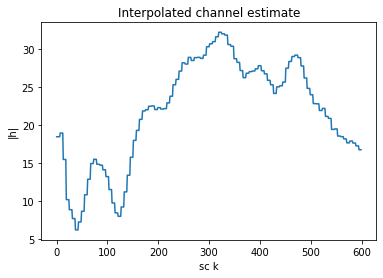

In [43]:
subf5_start = pss_start + N_FFT + int(4.5*Fs/1000) + (sfn%2)*2*half_frame
subf5_start += 4*(N_FFT + N_CP) + N_CP_extra
print(subf5_start)
ns = 10
l = 4
CP = N_CP
data = {'sym':rxf[subf5_start:subf5_start+N_FFT+CP],'ns':ns,'l':l,'rb':N_rb_dl,'fd':f_d,'h':[]}
ce = channel_estimate(N_id,N_CP,N_CP_extra,Fs,ant)
data = ce(data)

h_subf5 = np.zeros((2,600),complex)


for p in range(1):
    h_subf5[p] = data['h'][p]
 
        
for p in range(1):
    plt.plot(np.abs(h_subf5[p]))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.title('Interpolated channel estimate')
plt.show()


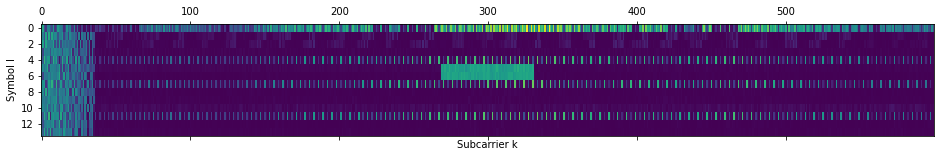

In [44]:
subf5=np.zeros((14,600),complex)

for n in range(14):
    subf5[n] = collector1[n]['sym']
    
plt.matshow(np.abs(subf5),aspect='auto')
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

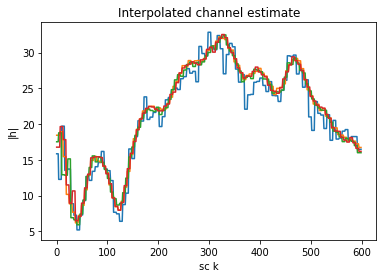

In [45]:
h_subf5 = np.zeros((2,4,600),complex)

k = 0
for n in [0,4,7,11]:
    for p in range(2):
        h_subf5[p][k] = collector1[n]['h'][p]
    k += 1
        
for p in range(1):
    for i in range(4):
        plt.plot(np.abs(h_subf5[p][i]))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.title('Interpolated channel estimate')
plt.show()

### circular buffer

In [74]:
class circular_buffer(object):
    # the length of incoming data is random.
    def __init__(self,size):
        
        self.read_pointer = 0
        self.write_pointer = 0
        self.size = size
        self.buf = [None]*size
        self.origin = False 
        # False: read behind write, read cannot pass write.
        # True: write behind read, write cannot pass read. 
        
    def read_data(self,length):
        assert length <= self.size
        if self.read_pointer + length <= self.size:
            return self.buf[self.read_pointer:self.read_pointer+length]
        else:
            return np.concatenate((self.buf[self.read_pointer:self.size],self.buf[:(self.read_pointer+length)%self.size]))
            
    def write_data(self,data):
        
        write_tmp = self.write_pointer + len(data)
        # big case 1: origin = false, read catch write
        if self.origin == False:
            if write_tmp < self.size:
                self.buf[self.write_pointer:write_tmp] = data
                self.write_pointer = write_tmp
            else: # pass the origin
                if write_tmp % self.size <= self.read_pointer: # not catch but write passes the origin
                    self.origin = True
                    self.buf[self.write_pointer:self.size] = data[:self.size-self.write_pointer]
                    self.buf[:write_tmp % self.size] = data[self.size-self.write_pointer:]
                    self.write_pointer = write_tmp % self.size
                else: # catch, data will be held.
                    print('warning')   
                    pass                 
        # big case 2: origin = true, write catch read
        else:
            if write_tmp <= self.read_pointer: # write not catch read
                self.buf[self.write_pointer:write_tmp] = data
                self.write_pointer = write_tmp
            else:
                print('warning')   
                pass # catch, data will be held
            
    def move_read(self,length): 
        
        read_tmp = self.read_pointer + length
        if self.origin == False:
            if read_tmp <= self.write_pointer:
                self.read_pointer = read_tmp
            else:
                print('warning')
                pass
        else:
            if read_tmp < self.size:
                self.read_pointer = read_tmp
            else: # pass the origin
                if read_tmp % self.size <= self.write_pointer:
                    self.read_pointer = read_tmp % self.size
                    self.origin = False
                else:
                    print('warning')
                    pass
                
    def reset_read(self):
        self.read_pointer = 0
        
    def reset_write(self):
        self.write_pointer = 0
                

In [87]:
cb = circular_buffer(1000)

data = np.arange(600)
cb.write_data(data)

cb.read_data(100)
cb.read_data(700)

cb.move_read(700)

cb.move_read(500)
print(cb.read_pointer,cb.write_pointer)
cb.read_data(150)

cb.move_read(200)
print(cb.read_pointer,cb.write_pointer)

data1 = np.arange(300)
cb.write_data(data1)

cb.read_data(700)
print(cb.read_pointer,cb.write_pointer)

# cb.write_data(data)
# print(cb.read_pointer,cb.write_pointer)

# data2 = np.arange(100)
# cb.write_data(data2)

data3 = np.arange(700)
cb.write_data(data3)

warning
500 600
warning
500 600
500 900
warning


### Controller

In [ ]:
class controller(object):
    
    def __init__(self,state_can,N_FFT,buf_size,Fs):
        
        # state machine
        self.state_can = state_can # e.g., ['search','mib','sib']
        self.state = state_can[0] # init at the first state
        
        # sys info
        self.read_pointer_in_buf = 0
        self.write_pointer_in_buf = 0
        
        self.N_FFT = N_FFT
        self.Fs = Fs
        self.half_frame = (Fs*5)//1000 # 5 ms 
        self.slot = half_frame // 10
        self.nsym_in_buf = 0
        self.res_in_buf = 0
        self.buf_size = buf_size
        self.send_start = 0
        self.mib_remaining = 4
        self.sib_remaining = 14
        
        self.N_id = 0
        self.fd = 0
        self.pss_start = 0
        
        self.sfn = 0
        self.bw = 0
        self.ant = 0
        self.c_phich = []      
        
    def update_write(self,control_info): 

        # update nsym and residue sym
        if control_info['write_position'] >= self.write_pointer_in_buf:
            # data in buf not pass origin
            tmp = control_info['write_position']
        else:   
            tmp = control_info['write_position'] + self.buf_size
        self.nsym_in_buf = (tmp-self.write_pointer_in_buf+self.res_in_buf) // N_FFT
        self.res_in_buf = (tmp-self.write_pointer_in_buf+self.res_in_buf) % N_FFT
        
        # update write pointer
        self.write_pointer_in_buf = control_info['write_position']
        
    def update_state(self,control_info):
        
        if control_info['source'] == 'search': # this means search has been completed
            self.state = 'mib'
        elif control_info['source'] == 'mib':
            self.state = 'sib'
        elif control_info['source'] == 'loss':
            self.state = 'search'
        else: # sib
            pass
        
    def update_sys(self,control_info):
        
        if control_info['source'] == 'search':
            self.N_id = control_info['info']['N_id']
            self.fd = control_info['info']['fd']      
            self.pss_start = control_info['info']['pss_start']    
        elif control_info['source'] == 'mib':
            self.sfn = control_info['info']['sfn']
            self.bw = control_info['info']['bw']
            self.ant = control_info['info']['ant']
            self.c_phich = control_info['info']['c_phich']
        elif control_info['source'] == 'sib':
            pass
                  
    def send_read(self):
        
        if self.state == 'search':
            pass
        elif self.state == 'mib': # this means the state has been transitioned to mib
            # if cell search is completed, the movement of read won't pass write pointer, note, return length of movement of read pointer
            self.read_pointer_in_buf += (self.pss_start + self.N_FFT) % self.buf_size
            return {'destination':'ring_buffer','read_move_size':self.pss_start+self.N_FFT} # should point to the first pss
        elif self.state == 'sib':
            dist_pbch_subf5 = int(4.5*self.Fs/1000) + (self.sfn%2)*2*self.half_frame
            if self.read_pointer_in_buf + dist_pbch_subf5 <= self.write_pointer_in_buf:
                self.read_pointer_in_buf += dist_pbch_subf5
                return {'destination':'ring_buffer','read_move_size':dist_pbch_subf5} 
            else:
                return None
        else: # loss
            dist_pbch_pss = 2*self.half_frame - self.N_FFT - self.N_CP
            dist_subf5_pss = self.half_frame + self.slot - self.N_FFT -self.N_CP
            if self.state == 'mib' and self.read_pointer_in_buf + dist_pbch_pss <= self.write_pointer_in_buf:
                self.read_pointer_in_buf +=  (2*self.half_frame - self.N_FFT - self.N_CP) % self.buf_size
                return {'destination':'ring_buffer','read_move_size':2*self.half_frame - self.N_FFT - self.N_CP} # should point to the first pss
            
            elif self.state == 'sib' and self.read_pointer_in_buf + dist_subf5_pss <= self.write_pointer_in_buf:
                self.read_pointer_in_buf += (self.half_frame + self.slot - self.N_FFT -self.N_CP) % self.buf_size
                return {'destination':'ring_buffer','read_move_size':self.half_frame + self.slot - self.N_FFT -self.N_CP} # should point to the first pss
            else:
                return None
                
    def send_write(self):
        if self.state == 'search': # sequentially send data in the ring buffer in terms of one OFDM size (N_FFT)
            if self.nsym_in_buf > 0:
                control_info = {'destination':'cell_search','start':self.send_start,'size':self.nsym_in_buf*N_FFT}
                self.send_start += self.nsym_in_buf*N_FFT
                self.nsym_in_buf = 0
                return control_info
            else:
                return None
            
        elif self.state == 'mib' or 'sib': # read pointer should be moved to the start of pbch
            # send_start should be reset to zero
            if self.state == 'mib':
                remaining = self.mib_remaining
            else:
                remaining = self.sib_remaining

            if remaining > 0:
                if 0 < self.nsym_in_buf < remaining:
                    
                    if self.state == 'mib':
                        control_info = {'destination':'mib_decoding','start':self.send_start,'size':self.nsym_in_buf*N_FFT} # modify to attach the sys info
                        self.mib_remaining -= self.nsym_in_buf
                    else:
                        control_info = {'destination':'sibs_decoding','start':self.send_start,'size':self.nsym_in_buf*N_FFT}
                        self.sib_remaining -= self.nsym_in_buf
                        
                    self.send_start += self.nsym_in_buf*N_FFT
                    self.nsym_in_buf = 0
                    return control_info
                elif self.nsym_in_buf >= remaining:
                    
                    if self.state == 'mib':
                        control_info = {'destination':'mib_decoding','start':self.send_start,'size':remaining*N_FFT}
                        self.mib_remaining = 0
                    else:
                        control_info = {'destination':'sibs_decoding','start':self.send_start,'size':remaining*N_FFT}
                        self.sib_remaining = 0 
                        
                    return control_info
                else: # nsym < 0 
                    return None
            else:
                return None
            
        
    def __call__(self,control_info): # the input can be control information from two sources: ring buffer and pipeline
        # we first don't consider message queue
        # the control information may need to clarify its source?
        # assume control_info has the form {'source','info'}
        if control_info['source'] == 'ring_buffer': 
            # control info from the ring buffer determines whether to send data to which pipeline related to the state.
            # control info from the pipeline will determine how to move the read pointer in the buffer
            self.update_write(control_info)
            return self.send_write() # control info of sending the data to the corresponding pipeline in ring buffer
            
        if control_info['source'] != 'ring_buffer': # control info from pipeline
            
            self.update_state(control_info)
            self.update_sys(control_info) 
            
            return self.send_read()    
        

In [91]:
a = 2
if a == 2 or a == 3:
    print(a)

2
